In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from segmentation_models_pytorch.utils.base import Loss

resume = 1
model_path = "/Users/amograo/Downloads/UNet_EB4_RLP-Artifacts/model_epoch_42.pth"

/home/sambal/segmentation/seg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [4]:
root = "../../Data"
# root = "/Users/amograo/Desktop/test/Dataset"
print(os.getcwd())
print(os.listdir(root))

/home/sambal/segmentation/PneumothoraxSegmentation/experiments
['png_files', 'old_csv', 'csv', '.git', 'mask_files']


In [5]:
images_dir = "png_files"
masks_dir = "mask_files"
train_csv = "csv/train_upsampled.csv"
val_csv = "csv/val_final.csv"

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image, cmap="gray")
    plt.show()

In [7]:
class Dataset(BaseDataset):

    def __init__(
        self,
        root,
        images_dir,
        masks_dir,
        csv,
        aug_fn=None,
        id_col="DICOM",
        aug_col="Augmentation",
        preprocessing_fn=None,
    ):
        images_dir = os.path.join(root, images_dir)
        masks_dir = os.path.join(root, masks_dir)
        df = pd.read_csv(os.path.join(root, csv))

        self.ids = [(r[id_col], r[aug_col]) for i, r in df.iterrows()]
        self.images = [os.path.join(images_dir, item[0] + ".png") for item in self.ids]
        self.masks = [
            os.path.join(masks_dir, item[0] + "_mask.png") for item in self.ids
        ]
        self.aug_fn = aug_fn
        self.preprocessing_fn = preprocessing_fn

    def __getitem__(self, i):

        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = (cv2.imread(self.masks[i], 0) == 255).astype("float")
        mask = np.expand_dims(mask, axis=-1)

        aug = self.ids[i][1]
        # if aug:
        augmented = self.aug_fn(aug)(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]

        if self.preprocessing_fn:
            sample = self.preprocessing_fn(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.ids)

In [8]:
from albumentations import (
    HorizontalFlip,
    RandomBrightnessContrast,
    RandomGamma,
    CLAHE,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    ShiftScaleRotate,
    Normalize,
    GaussNoise,
    Compose,
    Lambda,
    Resize,
)


def augmentation_fn(value, resize=21):
    augmentation_options = {
        0: [],
        1: [HorizontalFlip(p=1)],
        2: [RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)],
        3: [RandomGamma(p=1)],
        4: [CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=1)],
        5: [OpticalDistortion(p=1)],
        6: [ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=1)],
        7: [GaussNoise(p=1)],
        8: [
            HorizontalFlip(p=1),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            RandomGamma(p=1),
        ],
        9: [
            HorizontalFlip(p=1),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=1),
        ],
        10: [
            HorizontalFlip(p=1),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            OpticalDistortion(p=1),
        ],
        11: [
            HorizontalFlip(p=1),
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            GaussNoise(p=1),
        ],
        12: [
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=1),
            GaussNoise(p=1),
        ],
        13: [CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=1), GaussNoise(p=1)],
        14: [CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=1), OpticalDistortion(p=1)],
        15: [CLAHE(clip_limit=4.0, tile_grid_size=(4, 4), p=1), RandomGamma(p=1)],
        16: [RandomGamma(p=1), OpticalDistortion(p=1)],
        17: [
            RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            GaussNoise(p=1),
        ],
        18: [
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=1),
            RandomGamma(p=1),
        ],
        19: [
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=1),
            HorizontalFlip(p=1),
        ],
        20: [
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=1),
            GaussNoise(p=1),
            OpticalDistortion(p=1),
        ],
        21: [Resize(width=512, height=512, interpolation=cv2.INTER_AREA)],
    }

    return Compose(augmentation_options[resize] + augmentation_options[value])

In [9]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        Lambda(image=preprocessing_fn),
        Lambda(image=to_tensor, mask=to_tensor),
    ]
    return Compose(_transform)

16845
(512, 512, 3)
(512, 512, 1)
[0. 1.]
{0.0, 1.0}


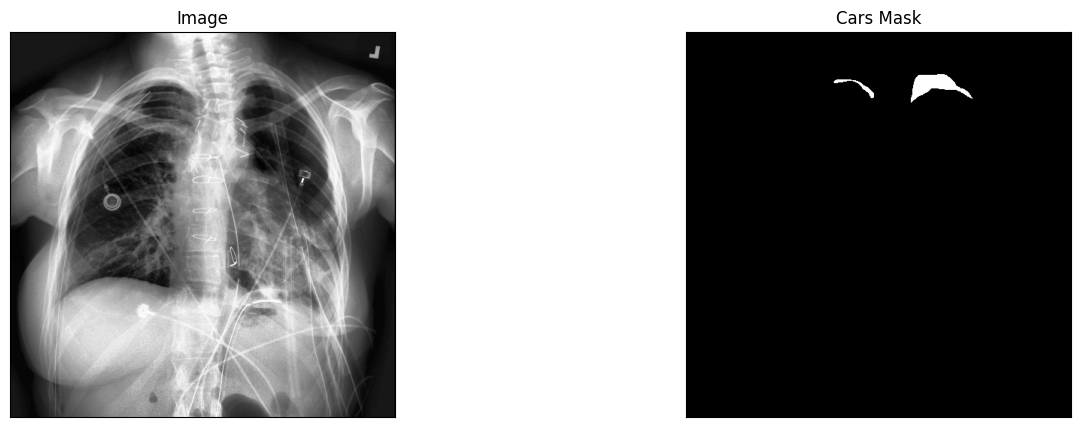

In [10]:
dataset = Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=train_csv,
    aug_fn=augmentation_fn,
)
print(len(dataset))
image, mask = dataset[1]  # get some sample
print(image.shape)
print(mask.shape)
print(np.unique(mask.squeeze()))
print(set(mask.flatten()))
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

In [11]:
class WeightedSumOfLosses(Loss):
    def __init__(self, l1, l2, w1=1, w2=0.5):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2
        self.w1 = w1
        self.w2 = w2

    def __call__(self, *inputs):
        return self.w1 * self.l1.forward(*inputs) + self.w2 * self.l2.forward(*inputs)

In [15]:
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = (
    "sigmoid"  # could be None for logits or 'softmax2d' for multiclass segmentation
)
DEVICE = "cuda"

# create segmentation model with pretrained encoder
epoch = -1
max_score = 0
val_loss = 0
train_loss = 0
train_iou = 0
val_iou = 0

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    activation=ACTIVATION,
).to(DEVICE)


loss = WeightedSumOfLosses(utils.losses.DiceLoss(), utils.losses.BCELoss())
metrics = [utils.metrics.IoU(threshold=0.5)]

optimizer = torch.optim.Adam(
    [
        dict(params=model.parameters(), lr=0.0001),
    ]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="max",
    factor=0.8,
    patience=2,
    threshold=0.01,
    threshold_mode="abs",
)


if resume:
    checkpoint = torch.load(f"{model_path}", map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss_function"]
    max_score = checkpoint["max_score"]
    val_loss = checkpoint["val_loss"]
    train_loss = checkpoint["train_loss"]
    train_iou = checkpoint["train_iou"]
    val_iou = checkpoint["val_iou"]
    started_lr = checkpoint["started_lr"]


print("Scheduler State Dict Outside: ", scheduler.state_dict())
print("Epoch:", epoch)
print("Loss Function:", loss)
print("Max Val Score:", max_score)
print(
    f"Train Iou: {train_iou}\nValid Iou: {val_iou}\nTrain Loss: {train_loss}\nVal Loss: {val_loss}"
)
print("Optimizer LR:", optimizer.param_groups[0]["lr"])

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amograo/Downloads/UNet_EB4_RLP-Artifacts/model_epoch_42.pth'

In [12]:
train_dataset=Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=train_csv,
    aug_fn=augmentation_fn,
    preprocessing_fn=get_preprocessing(preprocessing_fn)
)
print(len(train_dataset))

val_dataset=Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=val_csv,
    aug_fn=augmentation_fn,
    preprocessing_fn=get_preprocessing(preprocessing_fn)
)

# # print(len(val_dataset))

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
# valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


# test dataset without transformations for image visualization
train_dataset_vis = Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=train_csv,
    aug_fn=augmentation_fn,
)

val_dataset_vis = Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=val_csv,
    aug_fn=augmentation_fn,
)

16845


606


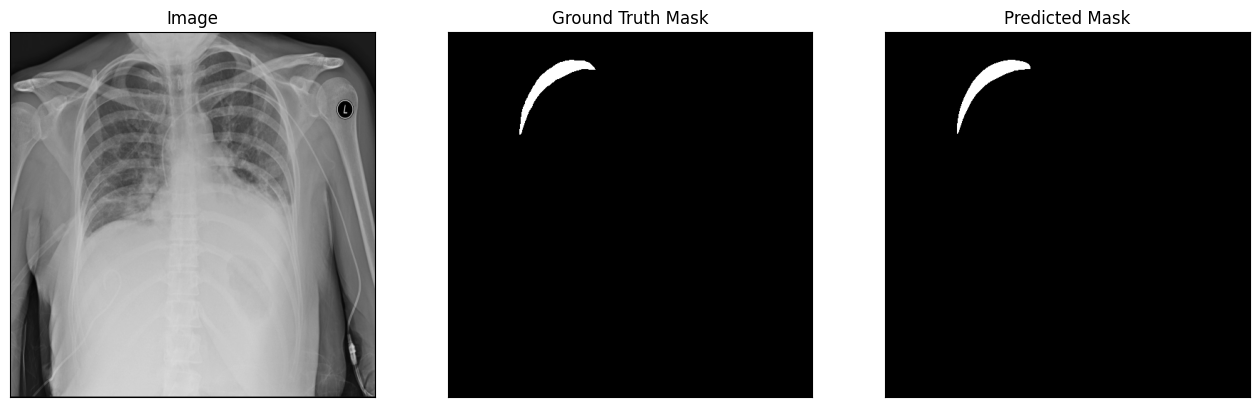

11533


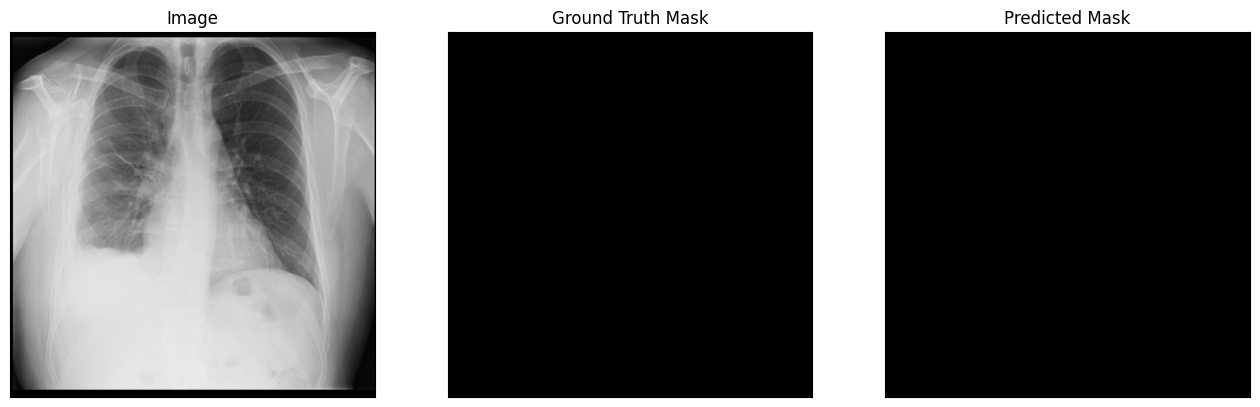

13988


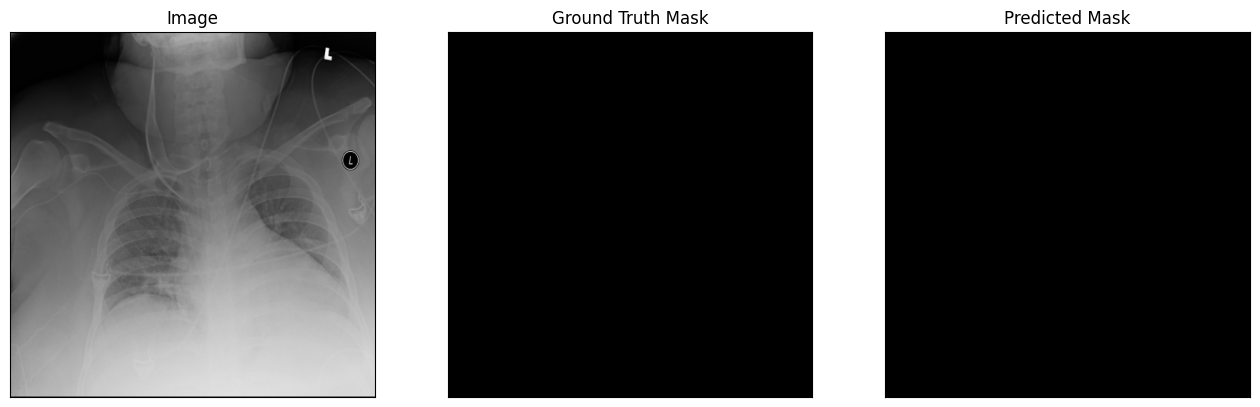

14316


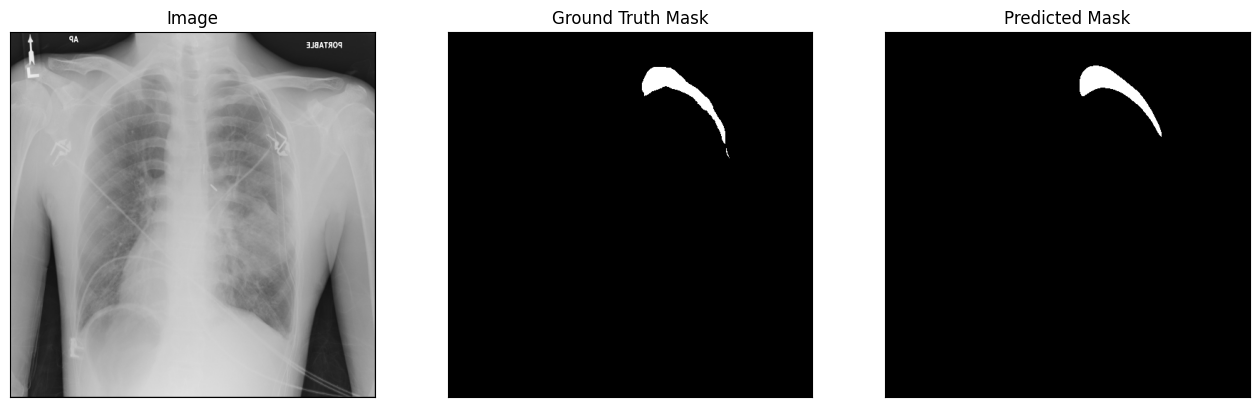

14418


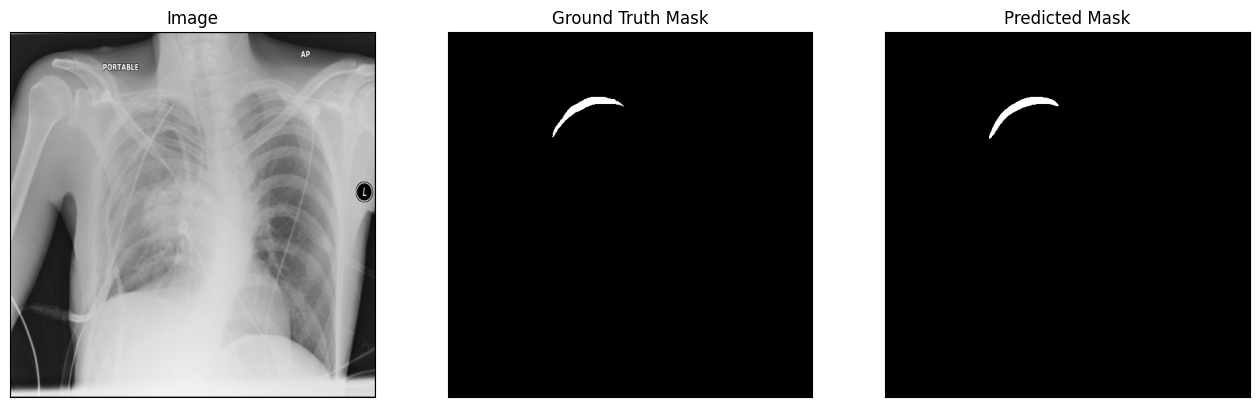

In [21]:

for i in range(5):
    n = np.random.choice(len(train_dataset))
    print(n)
    
    image_vis = train_dataset_vis[n][0].astype('uint8')
    image, gt_mask = train_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )


In [14]:
print(n)

15079


In [26]:
def resize(num):
    return Compose([Resize(width=num, height=num, interpolation=cv2.INTER_AREA)])

def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 1.0:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1
    return " ".join(rle) if len(rle) else "-1"

meta_df=pd.DataFrame(columns=["ImageId","EncodedPixels"])

In [24]:
val_df = pd.read_csv(os.path.join(root,val_csv))
eighth_column = val_df.iloc[ 7] 
print(eighth_column)

DICOM            1.2.276.0.7230010.3.1.4.8323329.3492.151787517...
Sex                                                              F
Age                                                             58
Pneumothorax                                                     0
View Position                                                   AP
Patient ID                    4b920032-e0e2-40b2-9ea1-7c61bd4685cf
Augmentation                                                     0
Name: 7, dtype: object


In [27]:
# run this on val, and check what the rle is, if there's an rle, then you know it's pneumothorax
# plot confusion matrix
true=[]
pred=[]

val_df = pd.read_csv(os.path.join(root,val_csv))

for i in range(len(val_dataset)):
    row = val_df.iloc[i]
    print(row['DICOM'],row['Pneumothorax'],sep=": ")
    image_vis = train_dataset_vis[i][0].astype('uint8')
    image, gt_mask = train_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    pr_mask_1024=resize(1024)(image=image_vis,mask=pr_mask)['mask']
    pr_rle=mask2rle(pr_mask_1024,1024,1024)

    print(pr_rle[:5])

    if pr_rle.strip()=="-1":
        pred.append(0)
    else:
        pred.append(1)

    true.append(row['Pneumothorax'])


1.2.276.0.7230010.3.1.4.8323329.5972.1517875193.343156: 0
-1
1.2.276.0.7230010.3.1.4.8323329.12355.1517875238.747383: 0
11329
1.2.276.0.7230010.3.1.4.8323329.6065.1517875195.904347: 0
-1
1.2.276.0.7230010.3.1.4.8323329.1543.1517875168.312014: 0
-1
1.2.276.0.7230010.3.1.4.8323329.6148.1517875196.740512: 0
-1
1.2.276.0.7230010.3.1.4.8323329.4485.1517875183.106811: 1
-1
1.2.276.0.7230010.3.1.4.8323329.3792.1517875179.438450: 0
17451
1.2.276.0.7230010.3.1.4.8323329.3492.1517875178.79475: 0
45632
1.2.276.0.7230010.3.1.4.8323329.31707.1517875156.417409: 0
-1
1.2.276.0.7230010.3.1.4.8323329.12223.1517875238.47629: 0
-1
1.2.276.0.7230010.3.1.4.8323329.1010.1517875165.904185: 0
21568
1.2.276.0.7230010.3.1.4.8323329.3965.1517875180.406042: 1
76396
1.2.276.0.7230010.3.1.4.8323329.3266.1517875176.969867: 0
15600
1.2.276.0.7230010.3.1.4.8323329.579.1517875163.536413: 0
18468
1.2.276.0.7230010.3.1.4.8323329.5023.1517875185.999033: 0
-1
1.2.276.0.7230010.3.1.4.8323329.1632.1517875168.659322: 1
29556


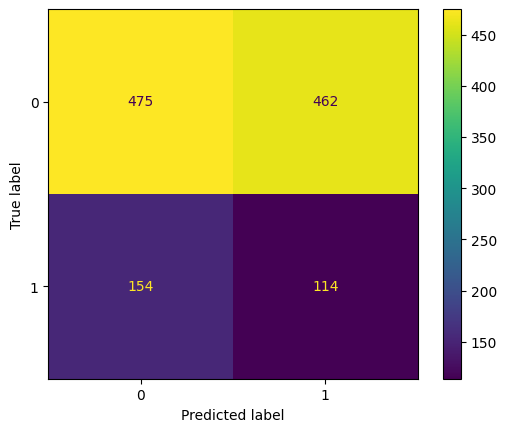

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
cm=confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [32]:
f1s=f1_score(true,pred)
print(f1s)

0.27014218009478674


In [35]:
cr=classification_report(true,pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.51      0.61       937
           1       0.20      0.43      0.27       268

    accuracy                           0.49      1205
   macro avg       0.48      0.47      0.44      1205
weighted avg       0.63      0.49      0.53      1205



In [37]:
valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

val_loader = DataLoader(val_dataset)

valid_epoch.run(val_loader)

valid: 100%|██████████| 1205/1205 [02:08<00:00,  9.41it/s, dice_loss + bce_loss - 0.2768, iou_score - 0.8224]


{'dice_loss + bce_loss': 0.2767704758472371, 'iou_score': 0.8223654952180318}